In [97]:
%matplotlib inline

In [98]:
import torch
import torch.optim as optim

import time
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import matplotlib.pyplot as plt

In [99]:
#отключает warnings pytorch
import warnings
warnings.filterwarnings('ignore')

In [100]:
DEVICE_ID = 2
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)

In [101]:
### Для запуска без GPU раскомментировать и закоментировать код выше
# DEVICE = torch.device('cpu')

In [102]:
np.random.seed(100500)

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    if isinstance(img, torch.Tensor): img = img.numpy().astype('uint8')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
def prediction2classes(output_var):
    _, predicted = torch.max(output_var.data, 1)
    predicted.squeeze_()
    classes = predicted.tolist()
    return classes

def make_solution_pytorch(net, input_tensor, a_batch_size):
    res = []
    net = net.eval()
    cur_pos = 0
    while cur_pos <= len(input_tensor):
        outputs = net(input_tensor[cur_pos:cur_pos+a_batch_size])
        res += prediction2classes(outputs)
        cur_pos += a_batch_size
    return res

In [103]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class CifarDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None):
                        
        data = np.load(input_path)
        if is_train: 
            self.Y, self.X = np.hsplit(data, [1]) 
            self.Y = [item[0] for item in self.Y]
        else: 
            self.X = data
            self.Y = None
            
        self.X = self.X.reshape((self.X.shape[0], 3, 32, 32))
        self.X = self.X.transpose((0, 2, 3, 1)) #приводим к виду (N, H, W, C)
        self.X = [Image.fromarray(img) for img in self.X]
                
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        sample = self.X[idx]

        if self.transform: sample = self.transform(sample)

        if self.Y is None: return sample
        else: return (sample, self.Y[idx])

In [104]:
#Надо поменять пути на свои до файлов с kaggle
DATA_PATH  = '/home/alexander.veselev/'
train_path = 'homework_4.train.npy'
test_path  = 'homework_4_no_classes.test.npy'
saved_net_path = 'saved_net.pth'

In [105]:
np_mean = np.mean([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))
np_std = np.std([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))

In [106]:
np_mean.shape

(3,)

In [107]:
cifar_transform_norm = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

cifar_test_transform_norm = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

In [108]:
# from tqdm import tqdm_notebook

dataset_train_norm = CifarDataset(DATA_PATH + train_path, transform=cifar_transform_norm)
dataloader_train_norm = DataLoader(dataset_train_norm, batch_size=128,
                        shuffle=True, num_workers=4)

dataset_test_norm = CifarDataset(DATA_PATH + test_path, is_train=False, transform=cifar_test_transform_norm)
dataloader_test_norm = DataLoader(dataset_test_norm, batch_size=128,
                        shuffle=False, num_workers=1)
saved_net_path = 'net_saved.pth'

def train_network(a_net, 
                  a_device,
                  dataloader_train_norm=dataloader_train_norm,
                  a_epochs=164,
                  a_batch_size=128,
                  a_lr=0.1):
    
    start_time = time.time()
    train_acc = []
    net = a_net.to(a_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.0001, momentum=0.9)

    prev_epoch_time = start_time
    for epoch in range(a_epochs):  # loop over the dataset multiple times
        if epoch == 42:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/10, weight_decay=0.0001, momentum=0.9) 
        elif epoch == 90:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/100, weight_decay=0.0001, momentum=0.9) 
        elif epoch == 123:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/250, weight_decay=0.0001, momentum=0.9)
         
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in dataloader_train_norm:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_accuracy += accuracy_score(labels.cpu(), prediction2classes(outputs))

        epoch_accuracy /= epoch_iters
        train_acc.append(epoch_accuracy)

        # saving the net state
        torch.save(net.state_dict(), DATA_PATH + saved_net_path)
        print("Epoch {}\t Train accuracy {}".format(epoch, round(train_acc[-1], 4)))
        cur_epoch_time = time.time()
        print('Epoch time : ', cur_epoch_time - prev_epoch_time )
        prev_epoch_time = cur_epoch_time
        
    print('Finished Training')
    print("Total time : ", (time.time()-start_time))
    
    plt.plot(train_acc, label='Train')
    plt.legend()
    plt.grid(c='grey')

In [109]:
DOWNSAMPLE_COEF = 2

def conv3x3(a_in_planes, a_out_planes, a_stride=1):
    """
    Основной строительный блок конволюций для ResNet
    Включает в себя padding=1 - чтобы размерность сохранялась после его применения
    """
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=3, padding=1, bias=False)

def x_downsample(a_in_channels, a_out_channels, stride):
     return nn.Conv2d(a_in_channels, 
               a_out_channels,
               kernel_size=1,
               stride=stride,
               bias=False)

In [110]:
class CifarResidualBlock(nn.Module):
    def __init__(self, a_in_channels, 
                       a_out_channels, 
                       stride=1,
                       make_downsample=False):
        super(CifarResidualBlock, self).__init__()
        self.make_downsample = make_downsample
        
        self.features = nn.Sequential()
        self.features.add_module('conv_1', conv3x3(a_in_channels, 
                                                   a_out_channels))
        self.features.add_module('bn_1', nn.BatchNorm2d(a_out_channels))
        self.features.add_module('relu_1', nn.ReLU())
        self.features.add_module('conv_2', conv3x3(a_out_channels, 
                                                   a_out_channels, 
                                                   a_stride=stride))
        self.features.add_module('bn_2', nn.BatchNorm2d(a_out_channels))
        self.features.add_module('relu_2', nn.ReLU())
        
        
        self.downsample =  nn.Sequential()
        if self.make_downsample:
            self.downsample = nn.Sequential(
                                     x_downsample(a_in_channels, 
                                                  a_out_channels, 
                                                  stride)
            )
    def forward(self, x):
        net = self.features(x)
        net += self.downsample(x)
        return net

In [111]:
class CifarResNet(nn.Module):
    
    def __init__(self):
        super(CifarResNet, self).__init__()        
        
        self.features = nn.Sequential()
        self.features.add_module('conv_1', conv3x3(3, 16))
        self.features.add_module('bn_1', nn.BatchNorm2d(16))
        self.features.add_module('relu_1', nn.LeakyReLU())
        self.features.add_module('cifar_1', 
                                 CifarResidualBlock(16, 64, 
                                                    make_downsample=True))
        self.features.add_module('cifar_2', 
                                 CifarResidualBlock(64, 64))
        self.features.add_module('dropout_1', 
                                 nn.Dropout(p=0.2))
        self.features.add_module('cifar_3', 
                                 CifarResidualBlock(64, 64))
        self.features.add_module('cifar_4', 
                                 CifarResidualBlock(64, 128, stride=2,
                                                    make_downsample=True))
        self.features.add_module('cifar_5', 
                                 CifarResidualBlock(128, 128))
        self.features.add_module('dropout_2', 
                                 nn.Dropout(p=0.2))
        self.features.add_module('cifar_6', 
                                 CifarResidualBlock(128, 128))
        self.features.add_module('cifar_7', 
                                 CifarResidualBlock(128, 256, stride=2,
                                                    make_downsample=True))
        self.features.add_module('cifar_8', 
                                 CifarResidualBlock(256, 256))
        self.features.add_module('dropout_3', 
                                 nn.Dropout(p=0.2))
        self.features.add_module('cifar_9', 
                                 CifarResidualBlock(256, 256))
        self.features.add_module('cifar_10', 
                                 CifarResidualBlock(256, 512, stride=2,
                                                    make_downsample=True))

        self.global_avg_pooling = nn.AvgPool2d(kernel_size=8)
        self.fc_classifier = nn.Linear(512, 100)
        
        
    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pooling(x)        
        x = x.view((x.size()[0], -1))        
        x = self.fc_classifier(x)        
        return x


Epoch 0	 Train accuracy 0.1024
Epoch time :  41.11146354675293
Epoch 1	 Train accuracy 0.2172
Epoch time :  41.813024282455444
Epoch 2	 Train accuracy 0.3115
Epoch time :  42.263654947280884
Epoch 3	 Train accuracy 0.3837
Epoch time :  43.07895469665527
Epoch 4	 Train accuracy 0.4411
Epoch time :  43.346132040023804
Epoch 5	 Train accuracy 0.4862
Epoch time :  43.16741943359375
Epoch 6	 Train accuracy 0.5179
Epoch time :  43.32621121406555
Epoch 7	 Train accuracy 0.5515
Epoch time :  43.48669672012329
Epoch 8	 Train accuracy 0.572
Epoch time :  43.518646478652954
Epoch 9	 Train accuracy 0.5998
Epoch time :  43.36449098587036
Epoch 10	 Train accuracy 0.6192
Epoch time :  43.49647259712219
Epoch 11	 Train accuracy 0.6358
Epoch time :  43.49483895301819
Epoch 12	 Train accuracy 0.6479
Epoch time :  43.43880867958069
Epoch 13	 Train accuracy 0.6647
Epoch time :  43.34212684631348
Epoch 14	 Train accuracy 0.674
Epoch time :  43.382230043411255
Epoch 15	 Train accuracy 0.6862
Epoch time :  4

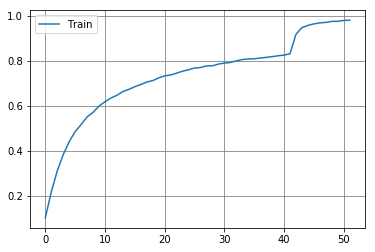

In [112]:
resnet = CifarResNet()
train_network(resnet, torch.device(DEVICE), a_epochs=52)

# Важно переключить сеть в режим eval - иначе dropout будет работать некорректно

In [113]:
def make_solution(a_net, a_device):
    res = []
    net = a_net.eval()
    for item in dataloader_test_norm:
        inputs = item.to(a_device)
        outputs = net(inputs) 

        res += prediction2classes(outputs)
    return res

In [114]:
my_solution = make_solution(resnet, DEVICE)

In [115]:
with open('submission.csv', 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(my_solution):
        print(i, prediction, sep=',', file=fout)